<a href="https://colab.research.google.com/github/engineereliab076/engineereliab076/blob/main/POTATO_DISEASE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install kaggle

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d arjuntejaswi/plant-village

 99% 325M/329M [00:03<00:00, 102MB/s] 
100% 329M/329M [00:03<00:00, 97.5MB/s]


In [9]:
#extracting the compressed data
from zipfile import ZipFile
dataset = '/content/plant-village.zip'

In [10]:
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [11]:


import shutil

shutil.rmtree('/content/PlantVillage/Pepper__bell___Bacterial_spot')
shutil.rmtree('/content/PlantVillage/Pepper__bell___healthy')
shutil.rmtree('/content/PlantVillage/Tomato_Bacterial_spot')
shutil.rmtree('/content/PlantVillage/Tomato_Early_blight')
shutil.rmtree('/content/PlantVillage/Tomato_Late_blight')
shutil.rmtree('/content/PlantVillage/Tomato_Leaf_Mold')
shutil.rmtree('/content/PlantVillage/Tomato_Septoria_leaf_spot')
shutil.rmtree('/content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite')
shutil.rmtree('/content/PlantVillage/Tomato__Target_Spot')
shutil.rmtree('/content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus')
shutil.rmtree('/content/PlantVillage/Tomato__Tomato_mosaic_virus')
shutil.rmtree('/content/PlantVillage/Tomato_healthy')

IMPORT THE DEPENDENCIES

In [12]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

Building a pipeline

In [14]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [16]:
#get class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [17]:
len(dataset)

68

In [18]:
#check the label data and number of image batches
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 2 0 1 1 1 1 0 1 1 1 0 0 2 1 1 0 1 1 1 0 1 0 0 2 1 1 1 2]


In [19]:
print(image_batch[0].numpy())

[[[ 99. 101. 113.]
  [106. 108. 120.]
  [112. 114. 126.]
  ...
  [130. 132. 145.]
  [133. 135. 148.]
  [135. 137. 150.]]

 [[122. 124. 136.]
  [120. 122. 134.]
  [125. 127. 139.]
  ...
  [139. 141. 154.]
  [140. 142. 155.]
  [141. 143. 156.]]

 [[109. 111. 123.]
  [104. 106. 118.]
  [117. 119. 131.]
  ...
  [142. 144. 157.]
  [141. 143. 156.]
  [140. 142. 155.]]

 ...

 [[105. 108. 125.]
  [109. 112. 129.]
  [113. 116. 133.]
  ...
  [115. 118. 137.]
  [112. 115. 134.]
  [113. 116. 135.]]

 [[ 86.  89. 106.]
  [ 95.  98. 115.]
  [106. 109. 126.]
  ...
  [129. 132. 151.]
  [128. 131. 150.]
  [132. 135. 154.]]

 [[ 96.  99. 116.]
  [ 98. 101. 118.]
  [101. 104. 121.]
  ...
  [121. 124. 143.]
  [123. 126. 145.]
  [129. 132. 151.]]]


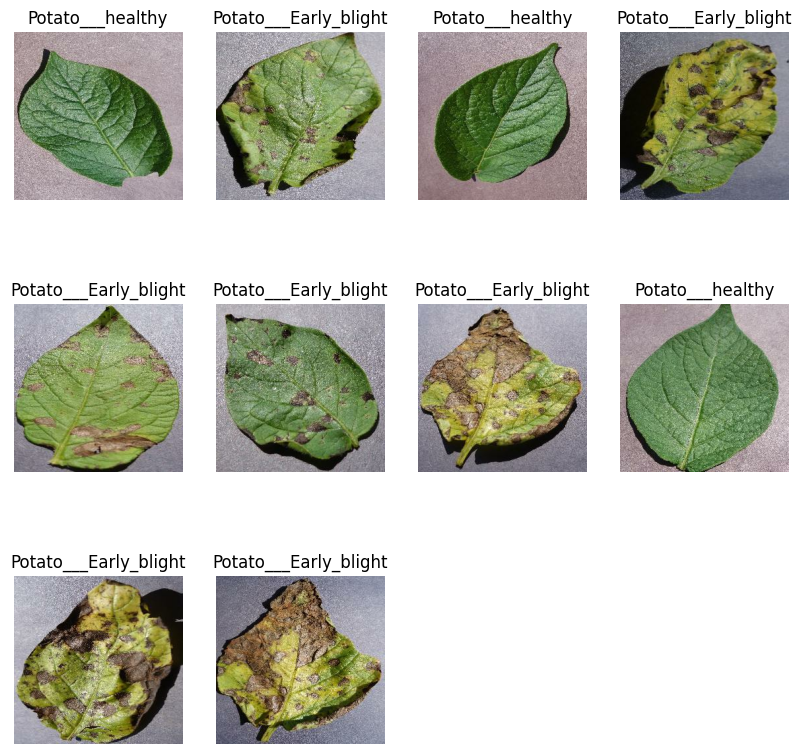

In [20]:
#view the first image
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[i]])

TRAIN VALIDATION TEST SPLIT

80% == TRAINING
10% == VALIDATION
10% == TEST

In [21]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [22]:
train_ds = dataset.take(54)
len(train_ds)

54

In [23]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [24]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [25]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [26]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [27]:
#create a partition file
def get_datset_partition_tf (ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle :
      ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = get_datset_partition_tf(dataset)

In [29]:
len(train_ds)

54

In [30]:
len(val_ds)

6

In [31]:
len(test_ds)

8

In [32]:
#dataset optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Data pre-processing

In [33]:
#resize and rescale

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [34]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

MODEL BUILDING
USED: CNN

In [35]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])
model.build(input_shape=input_shape)


In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [37]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history=model.fit(
    train_ds,epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 16s 112ms/step - loss: 0.9140 - accuracy: 0.4815 - val_loss: 0.8293 - val_accuracy: 0.5469
Epoch 2/50
54/54 [==============================] - 3s 59ms/step - loss: 0.6721 - accuracy: 0.6933 - val_loss: 0.4444 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 3s 59ms/step - loss: 0.4362 - accuracy: 0.8218 - val_loss: 0.4757 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.3256 - accuracy: 0.8623 - val_loss: 0.2171 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2805 - accuracy: 0.8924 - val_loss: 0.2491 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2447 - accuracy: 0.9074 - val_loss: 0.2823 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2294 - accuracy: 0.9057 - val_loss: 0.1750 - val_accuracy: 0.9427
Epoch 8/50


In [39]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 2s 27ms/step - loss: 0.0202 - accuracy: 0.9961


[0.020242299884557724, 0.99609375]

In [40]:
history

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

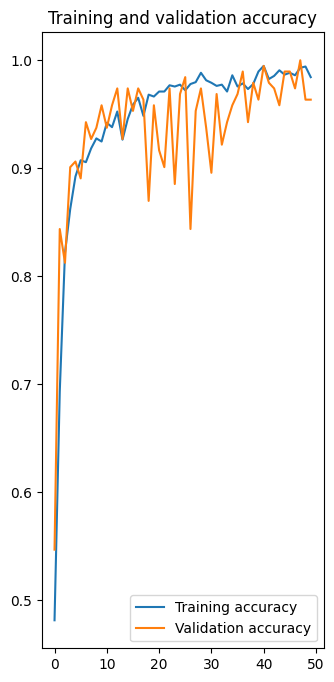

In [42]:
#plot
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

first image to predict
actual value: Potato___Late_blight
1/1 [==============================] - 0s 39ms/step
predicted Label: Potato___Late_blight


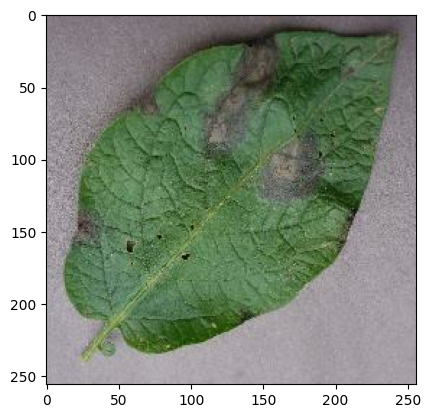

In [45]:
import numpy as np

for image_batch,label_batch in dataset.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print("actual value:", class_names[first_label])

  batch_pred = model.predict(image_batch)
  print("predicted Label:",class_names[np.argmax(batch_pred[0])])


In [47]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) #create a batch

  pred = model.predict(img_array)

  predicted_class = class_names[np.argmax(pred[0])]
  confidence = round(100*(np.max(pred[0])),2)

  return predicted_class,confidence

1/1 [==============================] - 0s 18ms/step
Actual:Potato___Early_blight,
 Predicted:Potato___Early_blight.
 Confidence:100.0%.
1/1 [==============================] - 0s 19ms/step
Actual:Potato___Early_blight,
 Predicted:Potato___Early_blight.
 Confidence:100.0%.
1/1 [==============================] - 0s 18ms/step
Actual:Potato___Late_blight,
 Predicted:Potato___Late_blight.
 Confidence:100.0%.
1/1 [==============================] - 0s 27ms/step
Actual:Potato___Late_blight,
 Predicted:Potato___Late_blight.
 Confidence:100.0%.
1/1 [==============================] - 0s 24ms/step
Actual:Potato___Early_blight,
 Predicted:Potato___Early_blight.
 Confidence:100.0%.
1/1 [==============================] - 0s 18ms/step
Actual:Potato___Late_blight,
 Predicted:Potato___Late_blight.
 Confidence:99.75%.
1/1 [==============================] - 0s 17ms/step
Actual:Potato___Early_blight,
 Predicted:Potato___Early_blight.
 Confidence:100.0%.
1/1 [==============================] - 0s 17ms/step
Ac

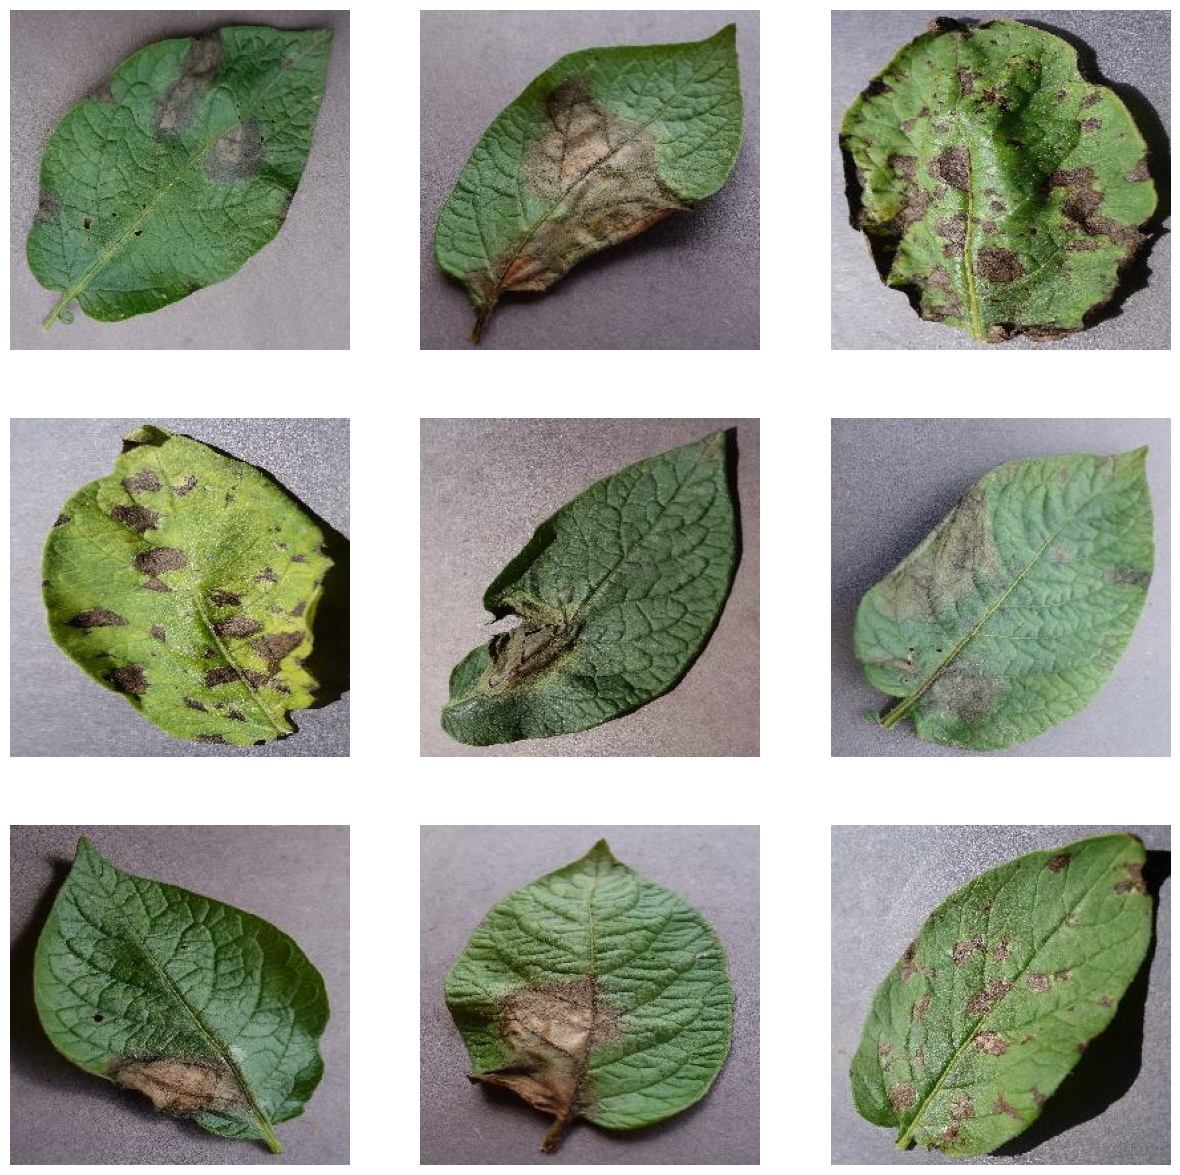

In [49]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))

    predicted_class,confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    print(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%.")

    plt.axis('off')

In [53]:
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")